In [ ]:
import torch 
import torch.nn as nn
from pytorch_metric_learning.losses import NTXentLoss
from torch.utils.data import Dataset, DataLoader
import random
import pandas as pd

In [ ]:
class ContrastiveLearning(torch.nn.Module):
    def __init__(self, input_dim, embedding_dim, projection_dim, dropout_rate=0.15):
        super(ContrastiveLearning, self).__init__()

        self.encoder = nn.Sequential(
                nn.Linear(input_dim, 1028),
                nn.BatchNorm1d(1028),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(1028, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(512, embedding_dim),
            )

        self.projector = nn.Sequential(
                nn.Linear(embedding_dim, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(256, projection_dim),
            )

        
    def forward(self, x):
        embedding = self.encoder(x)
        projection = self.projector(embedding)
        return projection

In [ ]:
criterion = NTXentLoss(temperature=0.10)

In [ ]:
import pandas as pd
data = pd.read_excel("data/synthetic_dataset.xlsx", index_col=0)
cluster_labels = pd.read_excel("data/clusters.xlsx", index_col=0)
cluster_labels.index = data.index
cluster_labels = cluster_labels[4]

In [ ]:
data

In [ ]:
cluster_labels

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = data.shape[1]
embedding_dim = 32
projection_dim = 8

model = ContrastiveLearning(input_dim, embedding_dim, projection_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
class ClusterContrastiveDataset(Dataset):
    def __init__(self, data, cluster_labels):
        self.data = data
        self.cluster_labels = cluster_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        label = self.cluster_labels.iloc[idx]
        positive_indices = [i for i, same_label in enumerate(self.cluster_labels) if same_label == label and i != idx]
        positive_idx = random.choice(positive_indices)
        positive_item = self.data.iloc[positive_idx]

        item_tensor = torch.tensor(item, dtype=torch.float32)
        positive_item_tensor = torch.tensor(positive_item, dtype=torch.float32)


        return item_tensor, positive_item_tensor

In [ ]:
dataset = ClusterContrastiveDataset(data=data, cluster_labels=cluster_labels)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)

In [ ]:
def train(num_epochs, log_interval): 

   for epoch in range(num_epochs):
        model.train()  
        total_loss = 0

        for batch_idx, (data_i, data_j) in enumerate(dataloader):

            data_i, data_j = data_i.float().to(device), data_j.float().to(device)

            optimizer.zero_grad()  

            projections_i = model(data_i)
            projections_j = model(data_j)

            # Concatenate the projections: 
            # The positive pairs are adjacent to each other, and all others are considered negatives.
            projections = torch.cat([projections_i, projections_j], dim=0)
            
            batch_size = projections_i.size(0)
            labels = torch.arange(batch_size, dtype=torch.long).to(device)
            labels = torch.cat((labels, labels), dim=0)  # Duplicate labels for both halves of concatenated data

            # Calculate the contrastive loss
            loss = criterion(projections, labels)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            if batch_idx % log_interval == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')

In [28]:
train(20,50)

C:\Users\emrek\AppData\Local\Temp\ipykernel_9992\652672158.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item_tensor = torch.tensor(item, dtype=torch.float32)
C:\Users\emrek\AppData\Local\Temp\ipykernel_9992\652672158.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  positive_item_tensor = torch.tensor(positive_item, dtype=torch.float32)


Epoch: 0, Batch: 0, Loss: 5.986716270446777
Epoch: 0, Batch: 50, Loss: 5.910808563232422
Epoch: 0, Batch: 100, Loss: 5.982677936553955
Epoch: 1, Batch: 0, Loss: 5.89607048034668
Epoch: 1, Batch: 50, Loss: 5.902013778686523
Epoch: 1, Batch: 100, Loss: 5.8834028244018555
Epoch: 2, Batch: 0, Loss: 5.887598037719727
Epoch: 2, Batch: 50, Loss: 5.884754180908203
Epoch: 2, Batch: 100, Loss: 5.818312168121338
Epoch: 3, Batch: 0, Loss: 5.809535503387451
Epoch: 3, Batch: 50, Loss: 5.882041931152344
Epoch: 3, Batch: 100, Loss: 5.790699005126953
Epoch: 4, Batch: 0, Loss: 5.787371635437012
Epoch: 4, Batch: 50, Loss: 5.788827419281006
Epoch: 4, Batch: 100, Loss: 5.764877796173096
Epoch: 5, Batch: 0, Loss: 5.725478172302246
Epoch: 5, Batch: 50, Loss: 5.769021034240723
Epoch: 5, Batch: 100, Loss: 5.770700931549072
Epoch: 6, Batch: 0, Loss: 5.7204909324646
Epoch: 6, Batch: 50, Loss: 5.753255844116211
Epoch: 6, Batch: 100, Loss: 5.7410383224487305
Epoch: 7, Batch: 0, Loss: 5.765988349914551
Epoch: 7, Ba

In [36]:
torch.save(model, "model.pkl")

In [ ]:
model = torch.load('model/model.pkl')

In [30]:
model.eval()

# Convert the Pandas series to a tensor and add an extra batch dimension
single_sample = torch.tensor(dataset.data.iloc[100].values).float().unsqueeze(0)

model.encoder(single_sample)

tensor([[ 3.4184, -1.8614,  2.0643, -4.8618, -0.4873,  6.1240,  2.3591, -3.5761,
         -3.2758, -1.5182, -2.9935, -1.2115,  3.8389, -2.2434,  0.2898, -0.6267,
          0.7240, -0.8349,  1.3940, -0.0859, -5.0045,  1.4073,  4.7017,  1.7282,
         -1.7920,  1.2189,  1.1193,  0.0525, -1.0059, -2.3703,  0.3531, -0.2180]],
       grad_fn=<AddmmBackward0>)

In [31]:
from finch import FINCH

embeddings = model.encoder(torch.tensor(dataset.data.values).float()).detach()

if embeddings.is_cuda:
    embeddings = embeddings.cpu()

embeddings_np = embeddings.numpy()

c, num_clust, req_c = FINCH(embeddings_np)

Partition 0: 10259 clusters
Partition 1: 1526 clusters
Partition 2: 261 clusters
Partition 3: 55 clusters
Partition 4: 14 clusters
Partition 5: 5 clusters


In [32]:
new_clusters =  pd.DataFrame(c)[5].values

In [33]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari_score = adjusted_rand_score(cluster_labels.values, new_clusters)
nmi_score = normalized_mutual_info_score( cluster_labels.values, new_clusters)

print("Adjusted Rand Index:", ari_score)
print("Normalized Mutual Information:", nmi_score)

Adjusted Rand Index: 0.9946295215276801
Normalized Mutual Information: 0.986795399340468


In [34]:
pd.DataFrame(embeddings, index = cluster_labels.index)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.155312,-0.031795,1.528037,-2.698554,-1.386769,2.211668,2.482651,-3.783729,-3.404649,-1.648523,...,3.792995,1.684288,-2.474405,0.091349,-1.146816,-3.425648,0.583444,-0.839881,-2.719033,1.026858
1,0.553144,0.094541,0.654804,-2.057061,-0.679160,2.187508,1.883165,-2.707069,-2.226369,-0.908328,...,3.163127,1.751484,-1.908596,0.358577,-0.661421,-2.112000,0.288593,-0.530810,-1.269308,0.613522
2,-0.936899,0.333013,-0.282243,-0.685293,0.412586,2.061793,1.496484,-1.307413,-2.820465,-0.567926,...,2.751837,2.818817,-0.448536,-1.266732,-2.160098,-1.487694,1.539812,0.430695,-1.447185,0.524974
3,0.065332,0.726761,-0.262341,0.035614,-0.546733,-1.289639,-0.095494,-0.709481,0.368345,0.346466,...,-0.273226,0.277689,-0.516919,0.694988,0.551576,-1.149204,0.202084,0.394380,0.140964,-0.111404
4,1.988974,-1.458711,1.289753,-2.147199,-1.257374,4.486857,1.890030,-3.226618,-3.896538,-0.831338,...,3.826290,0.698792,-1.564000,-1.074618,-1.743994,-0.952323,-0.383008,-1.285130,-1.516468,0.105591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71616,-0.136374,-0.917642,-0.386652,-0.381032,-0.361102,2.502550,0.119443,0.335776,-2.114555,0.412214,...,1.058763,1.957411,0.391197,-1.543718,-2.172600,0.996515,0.712250,0.411617,-0.749586,0.423914
71617,1.237782,0.080505,0.561357,-0.667034,-0.889785,1.099635,0.874647,-1.574666,-0.988550,-1.154920,...,1.730172,0.172109,-1.597862,0.037545,0.417178,-1.173566,-0.078838,-0.368482,-0.789934,-0.591175
71618,0.443538,-0.054263,-0.700771,-0.027542,0.650092,1.194812,0.437683,0.679292,0.828302,-0.012468,...,0.310234,1.104593,0.186141,1.057368,1.074383,1.707190,0.063840,0.087594,0.898694,-0.190682
71619,-2.958108,2.102149,-0.198124,2.714313,-1.520043,-4.870540,-0.298696,1.792306,3.706986,2.396325,...,-4.616985,-1.884607,1.442668,1.366400,1.783714,-1.233814,1.561004,3.877851,0.485304,-0.424936


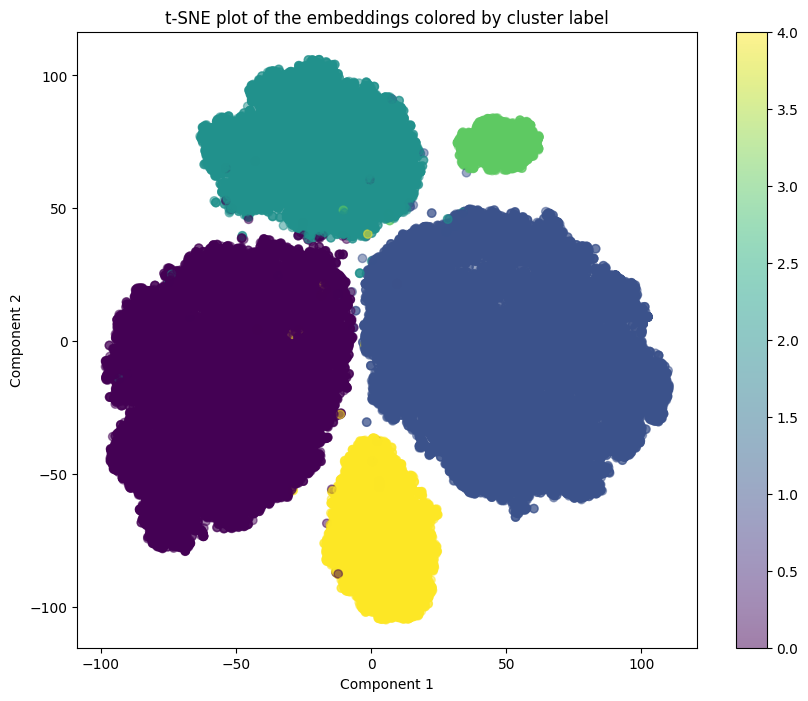

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'embeddings' is a numpy array of your data embeddings
# And 'cluster_labels' is an array of cluster labels corresponding to each point in 'embeddings'
embeddings_2d = TSNE(n_components=2, random_state=0).fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=new_clusters, cmap='viridis', alpha=0.5)
plt.colorbar()  # To show the color scale
plt.title('t-SNE plot of the embeddings colored by cluster label')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

data = pd.read_excel("data/synthetic_dataset.xlsx", index_col=0)
embeddings_2d = TSNE(n_components=2, random_state=0).fit_transform(data)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.colorbar()  # To show the color scale
plt.title('t-SNE plot of the actual data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## Evaluation 

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
recipes = pd.read_excel("data/clustered_data.xlsx", index_col=0)
recipes.drop("cluster_labels", axis=1, inplace=True)

In [ ]:
test_set = pd.read_excel("data/recipe_logs.xlsx", index_col=0)
test_set.drop("id", axis=1, inplace=True)
users_feedback = test_set
labels = users_feedback.is_accepted

In [ ]:
users_feedback

In [ ]:
recipes = recipes.loc[users_feedback.recipe_id.values]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(recipes, labels, test_size=0.20, random_state=42, stratify=labels)

In [ ]:
simple_LR = LogisticRegression(penalty='l2', C=0.1, n_jobs=-1, max_iter=1000)
contastive_LR = LogisticRegression(penalty='l2', C=0.1, n_jobs=-1, max_iter=1000)

In [ ]:
simple_LR.fit(X_train,y_train)
embeddings = model.encoder(torch.tensor(X_train.values).float()).detach()
embedding_test = model.encoder(torch.tensor(X_test.values).float()).detach()
contastive_LR.fit(embeddings, y_train)

In [ ]:
simple_LR.score(X_train,y_train)

In [ ]:
contastive_LR.score(embeddings,y_train)

In [ ]:
simple_LR.predict(X_train)

In [ ]:
contastive_LR.predict(embeddings).sum()

In [ ]:
simple_LR.score(X_test,y_test)

In [ ]:
contastive_LR.score(embedding_test,y_test)